# Görsel Verilerinin Kırpılması, İşaretlenmesi ve Eğitim

In [1]:
# Kütüphaneler

import os
import cv2
import numpy as np
import mediapipe as mp
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
import time
import socket

⛔ El bulunamadı: 0067b633-b7da-4ecd-ad0c-635d1b30afb9.jpg
⛔ El bulunamadı: 009ffa3f-8cb0-48f7-8036-367e4523d4b7.jpg
⛔ El bulunamadı: 0149fc0e-511a-4216-8300-f5c259f43ec3.jpg
⛔ El bulunamadı: 0160dd48-f1e5-462f-a784-147705477977.jpg
⛔ El bulunamadı: 0279a7d3-2be1-4e66-b8a2-18fc175fc5a1.jpg
⛔ El bulunamadı: 029ecb08-9e63-4d1b-a016-a86869bc0808.jpg
⛔ El bulunamadı: 030c6b99-363a-47bc-954a-1ca8752353f8.jpg
⛔ El bulunamadı: 03363c96-ae40-415f-9e08-a6cc20789b7f.jpg
⛔ El bulunamadı: 042fa2fd-169f-41cc-a0b7-85a5c194ecaf.jpg
⛔ El bulunamadı: 043ad4c5-287e-44c0-9354-e6e5f45f3d59.jpg
⛔ El bulunamadı: 046f7f1a-a473-4c64-b58d-02723ec73502.jpg
⛔ El bulunamadı: 0563d22a-ed0e-4280-a7b3-c9c747eddb4e.jpg
⛔ El bulunamadı: 062c5f38-ea14-42fc-8d71-008800641657.jpg
⛔ El bulunamadı: 063b86ff-f21b-40c3-8597-31a3fef73ed8.jpg
⛔ El bulunamadı: 0649e746-39b4-4148-82d8-4242e30392f1.jpg
⛔ El bulunamadı: 0658dd37-1357-432d-ac68-4e6397513634.jpg
⛔ El bulunamadı: 072fb5b7-df4f-4ec2-9926-d102f97694b4.jpg
⛔ El bulunamad

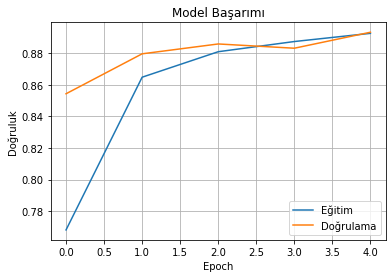

In [ ]:
# 1. Klasör yolları
RAW_FOLDER = 'data'
CROP_FOLDER = 'veri/kirpilmis_gorseller'
IMG_SIZE = 224
BATCH_SIZE = 32

# 2. MediaPipe ile kırp
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(
    static_image_mode=True,
    max_num_hands=1,
    min_detection_confidence=0.3
)


os.makedirs(CROP_FOLDER, exist_ok=True)

def crop_hand(image):
    results = hands.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    if results.multi_hand_landmarks:
        h, w, _ = image.shape
        landmarks = results.multi_hand_landmarks[0].landmark
        xs = [lm.x for lm in landmarks]
        ys = [lm.y for lm in landmarks]
        xmin = int(min(xs) * w) - 20
        xmax = int(max(xs) * w) + 20
        ymin = int(min(ys) * h) - 20
        ymax = int(max(ys) * h) + 20
        xmin = max(xmin, 0)
        ymin = max(ymin, 0)
        xmax = min(xmax, w)
        ymax = min(ymax, h)
        return image[ymin:ymax, xmin:xmax]
    return None

# 3. Klasördeki tüm görselleri işle
for class_folder in os.listdir(RAW_FOLDER):
    class_path = os.path.join(RAW_FOLDER, class_folder)
    output_class_path = os.path.join(CROP_FOLDER, class_folder)
    os.makedirs(output_class_path, exist_ok=True)

    for filename in os.listdir(class_path):
        if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
            img_path = os.path.join(class_path, filename)
            img = cv2.imread(img_path)

            cropped = crop_hand(img)
            if cropped is not None:
                resized = cv2.resize(cropped, (IMG_SIZE, IMG_SIZE))
                save_path = os.path.join(output_class_path, filename)
                cv2.imwrite(save_path, resized)
            else:
                print(f"⛔ El bulunamadı: {filename}")

# 4. Veri yükleyici
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=10,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.7, 1.3],
    horizontal_flip=True
)

train_gen = datagen.flow_from_directory(
    CROP_FOLDER,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

val_gen = datagen.flow_from_directory(
    CROP_FOLDER,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

num_classes = train_gen.num_classes

# 5. Model (MobileNetV2 + Dense)
base_model = MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False, weights='imagenet')
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
output = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# 6. Eğitim
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=5
)

# 7. Başarım Grafiği
plt.plot(history.history['accuracy'], label='Eğitim')
plt.plot(history.history['val_accuracy'], label='Doğrulama')
plt.title('Model Başarımı')
plt.xlabel('Epoch')
plt.ylabel('Doğruluk')
plt.legend()
plt.grid()
plt.show()

# 8. Modeli Kaydet
model.save("el_modeli_mobilenetv2.h5")


### Başarı metriklerini incelediğimizde sağlıklı bir eğitim gözlemliyoruz. Doğrulama verisi daima eğitimden daha yüksek, ayrıca her epochta sürekli iyileşme bulunuyor.

In [ ]:
# TETRİS GESTURE SERVER (Port 65432)

# 🔧 Model ve ayarlar
model = load_model("el_modeli_mobilenetv2.h5")
class_names = ['dislike', 'fist', 'like', 'no_gesture', 'one', 'palm', 'timeout']
IMG_SIZE = 224

# 🖐️ MediaPipe
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=False, max_num_hands=1, min_detection_confidence=0.5)
mp_draw = mp.solutions.drawing_utils

# 🎥 Kamera
cap = cv2.VideoCapture(0)

# 🔌 Socket sunucu
sock = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
sock.bind(("localhost", 65432))
sock.listen(1)
print("🎯 Gesture server listening on port 65432...")
conn, addr = sock.accept()
print(f"✅ Connected to {addr}")

# ⏱ Tahmin süresi
prediction_interval = 1
last_prediction_time = time.time()

def preprocess_hand(image, bbox):
    x1, y1, x2, y2 = bbox
    cropped = image[y1:y2, x1:x2]
    resized = cv2.resize(cropped, (IMG_SIZE, IMG_SIZE))
    norm = resized / 255.0
    return np.expand_dims(norm, axis=0)

def get_bbox_from_landmarks(landmarks, width, height):
    xs = [lm.x for lm in landmarks]
    ys = [lm.y for lm in landmarks]
    x_min = max(int(min(xs) * width) - 20, 0)
    y_min = max(int(min(ys) * height) - 20, 0)
    x_max = min(int(max(xs) * width) + 20, width)
    y_max = min(int(max(ys) * height) + 20, height)
    return x_min, y_min, x_max, y_max

while True:
    ret, frame = cap.read()
    if not ret:
        break

    img_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = hands.process(img_rgb)

    if results.multi_hand_landmarks:
        h, w, _ = frame.shape
        for handLms in results.multi_hand_landmarks:
            bbox = get_bbox_from_landmarks(handLms.landmark, w, h)
            current_time = time.time()

            if current_time - last_prediction_time >= prediction_interval:
                try:
                    input_img = preprocess_hand(frame, bbox)
                    preds = model.predict(input_img, verbose=0)
                    pred_class = class_names[np.argmax(preds)]
                    last_prediction_time = current_time

                    # 🧠 Gesture → Komut eşleşmesi
                    mapped_command = {
                        "fist": "drop",
                        "palm": "left",
                        "one": "right",
                        "like": "rotate_left",
                        "dislike": "rotate_right",
                        "timeout": "pause"
                    }.get(pred_class, "none")

                    conn.sendall(mapped_command.encode())
                    print(f"🖐️ Gesture: {pred_class} → Komut: {mapped_command}")

                except Exception as e:
                    print("❗ Hata:", e)

            mp_draw.draw_landmarks(frame, handLms, mp_hands.HAND_CONNECTIONS)

    cv2.imshow("Gesture Prediction", frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()
conn.close()
sock.close()


🎯 Gesture server listening on port 65432...
✅ Connected to ('127.0.0.1', 50932)
🖐️ Gesture: dislike → Komut: rotate_right
🖐️ Gesture: dislike → Komut: rotate_right
🖐️ Gesture: dislike → Komut: rotate_right
🖐️ Gesture: palm → Komut: left
🖐️ Gesture: palm → Komut: left
🖐️ Gesture: palm → Komut: left
🖐️ Gesture: palm → Komut: left
🖐️ Gesture: one → Komut: right
🖐️ Gesture: one → Komut: right
🖐️ Gesture: like → Komut: rotate_left
🖐️ Gesture: like → Komut: rotate_left
🖐️ Gesture: like → Komut: rotate_left
🖐️ Gesture: like → Komut: rotate_left
🖐️ Gesture: fist → Komut: drop
🖐️ Gesture: one → Komut: right
🖐️ Gesture: one → Komut: right
🖐️ Gesture: palm → Komut: left
🖐️ Gesture: palm → Komut: left
🖐️ Gesture: one → Komut: right
🖐️ Gesture: one → Komut: right
🖐️ Gesture: fist → Komut: drop
🖐️ Gesture: one → Komut: right
🖐️ Gesture: one → Komut: right
🖐️ Gesture: one → Komut: right
🖐️ Gesture: one → Komut: right
🖐️ Gesture: palm → Komut: left
🖐️ Gesture: palm → Komut: left
🖐️ Gesture: palm → Kom

In [ ]:
# JETPACK GESTURE SERVER (Port 65433)

PORT = 65433
COMMAND_MAP = {
    "palm": "open",        # yukarı uç
    "fist": "fist",        # aşağı bırak
    "timeout": "timeout"   # duraklat/devam et
}

model = load_model("el_modeli_mobilenetv2.h5")
class_names = ['dislike', 'fist', 'like', 'no_gesture', 'one', 'palm', 'timeout']
IMG_SIZE = 224

mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=False, max_num_hands=1, min_detection_confidence=0.5)
mp_draw = mp.solutions.drawing_utils

cap = cv2.VideoCapture(0)
sock = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
sock.bind(("localhost", PORT))
sock.listen(1)
print(f"🎯 Jetpack gesture server listening on port {PORT}...")
conn, addr = sock.accept()
print(f"✅ Connected to {addr}")

prediction_interval = 0.05  # daha hassas
last_prediction_time = time.time()

def preprocess_hand(image, bbox):
    x1, y1, x2, y2 = bbox
    cropped = image[y1:y2, x1:x2]
    resized = cv2.resize(cropped, (IMG_SIZE, IMG_SIZE))
    norm = resized / 255.0
    return np.expand_dims(norm, axis=0)

def get_bbox_from_landmarks(landmarks, width, height):
    xs = [lm.x for lm in landmarks]
    ys = [lm.y for lm in landmarks]
    x_min = max(int(min(xs) * width) - 20, 0)
    y_min = max(int(min(ys) * height) - 20, 0)
    x_max = min(int(max(xs) * width) + 20, width)
    y_max = min(int(max(ys) * height) + 20, height)
    return x_min, y_min, x_max, y_max

while True:
    ret, frame = cap.read()
    if not ret:
        break

    img_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = hands.process(img_rgb)

    if results.multi_hand_landmarks:
        h, w, _ = frame.shape
        for handLms in results.multi_hand_landmarks:
            bbox = get_bbox_from_landmarks(handLms.landmark, w, h)
            current_time = time.time()

            if current_time - last_prediction_time >= prediction_interval:
                try:
                    input_img = preprocess_hand(frame, bbox)
                    preds = model.predict(input_img, verbose=0)
                    pred_class = class_names[np.argmax(preds)]
                    last_prediction_time = current_time
                    cmd = COMMAND_MAP.get(pred_class, "none")

                    if cmd != "none":
                        conn.sendall(cmd.encode())
                        print(f"🖐️ Gesture: {pred_class} → Komut: {cmd}")

                except Exception as e:
                    print("❗ Hata:", e)

            mp_draw.draw_landmarks(frame, handLms, mp_hands.HAND_CONNECTIONS)

    cv2.imshow("Gesture Prediction - Jetpack", frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()
conn.close()
sock.close()

🎯 Jetpack gesture server listening on port 65433...
✅ Connected to ('127.0.0.1', 51100)
🖐️ Gesture: palm → Komut: open
🖐️ Gesture: palm → Komut: open
🖐️ Gesture: palm → Komut: open
🖐️ Gesture: palm → Komut: open
🖐️ Gesture: fist → Komut: fist
🖐️ Gesture: timeout → Komut: timeout
🖐️ Gesture: timeout → Komut: timeout
🖐️ Gesture: fist → Komut: fist
🖐️ Gesture: timeout → Komut: timeout
🖐️ Gesture: timeout → Komut: timeout
🖐️ Gesture: timeout → Komut: timeout
🖐️ Gesture: timeout → Komut: timeout
🖐️ Gesture: timeout → Komut: timeout
🖐️ Gesture: timeout → Komut: timeout
🖐️ Gesture: timeout → Komut: timeout
🖐️ Gesture: timeout → Komut: timeout
🖐️ Gesture: timeout → Komut: timeout
🖐️ Gesture: timeout → Komut: timeout
🖐️ Gesture: timeout → Komut: timeout
🖐️ Gesture: palm → Komut: open
🖐️ Gesture: palm → Komut: open
🖐️ Gesture: palm → Komut: open
🖐️ Gesture: fist → Komut: fist
🖐️ Gesture: fist → Komut: fist
🖐️ Gesture: fist → Komut: fist
🖐️ Gesture: fist → Komut: fist
🖐️ Gesture: fist → Komut: fi